<a href="https://colab.research.google.com/github/acmoral/QuantumGenerativeBaselines/blob/master/QRBM_KaggleKey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#QRBM for image reconstruction implementation


Universidad Nacional de Colombia

Sergio Quiroga Sandoval squirogas@unal.edu.co


A complete reproduction of the QRBM implemented at https://github.com/mareksubocz/QRBM, and reported in the paper [1](https://cmst.eu/articles/applying-a-quantum-annealing-based-restricted-boltzmann-machine-for-mnist-handwritten-digit-classification/)

### Cloning repository and imports:

In [1]:
# Clone the QRBM repository
!git clone https://github.com/mareksubocz/QRBM.git

# Install everything in binder/requirements.txt
!pip install -r QRBM/binder/requirements.txt


import sys
# Adjust path if you cloned somewhere else
sys.path.append('/content/QRBM')


fatal: destination path 'QRBM' already exists and is not an empty directory.
  Cloning https://github.com/mareksubocz/jupyter-drawing-pad.git to /tmp/pip-install-jcguodsd/jupyter-drawing-pad_e258319cdf384de59bdea92f394b987c
  Running command git clone --filter=blob:none --quiet https://github.com/mareksubocz/jupyter-drawing-pad.git /tmp/pip-install-jcguodsd/jupyter-drawing-pad_e258319cdf384de59bdea92f394b987c
  Resolved https://github.com/mareksubocz/jupyter-drawing-pad.git to commit 1553302be8791f735de9febc91b2f07b7819c030
  Preparing metadata (setup.py) ... done


In [2]:
!pip install pyqubo      # brings in the PyQUBO library for building QUBO models :contentReference[oaicite:1]{index=1}
!pip install dwave-tabu   # installs the TabuSampler interface (provides top-level `tabu` module) :contentReference[oaicite:2]{index=2}

In [3]:
import numpy as np
import timeit
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from qrbm.MSQRBM import MSQRBM
from qrbm.classicalRBM import classicalRBM


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

import pandas as pd

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import img_as_bool

import cv2 as cv

import random

### Dataset and image processing:

Parameters:
* Digits: list of digits to train on
* THRESHOLD: how bright parts of image become 1 (darker become 0).

In [4]:
image_height = 28
image_width = 28

# images will be flattened
len_x = image_height * image_width
len_y = 0

digits = [0, 1]

THRESHOLD = 100

In [5]:
# reading datasetn
# 1. Install opendatasets
!pip install opendatasets

# 2. Download & unzip directly from Kaggle’s “Datasets” page
import opendatasets as od
od.download(
    "https://www.kaggle.com/oddrationale/mnist-in-csv",
    data_dir="data"
)  # creates data/mnist-in-csv

# 3. Read CSVs
import pandas as pd
mnist_dataset = pd.read_csv('data/mnist-in-csv/mnist_train.csv')
mnist_test    = pd.read_csv('data/mnist-in-csv/mnist_test.csv')


# Train Test sets

X_train = mnist_dataset.values[:,1:]
X_train2 = mnist_dataset.values[:,:]

X_test = mnist_test.values[:,1:]
X_test2 = mnist_test.values[:,:]

# print(mnist_dataset.values[:,0])
X_train3 = []
X_test3 = []

for digit in digits:
    X_train3.append(mnist_dataset.values[np.where(mnist_dataset.values[:,0] == digit), 1:][0])
    X_test3.append(mnist_test.values[np.where(mnist_test.values[:,0] == digit), 1:][0])
# X_train3 = mnist_dataset.values[np.where(mnist_dataset.values[:,0] == 0), 1:]

Skipping, found downloaded files in "data/mnist-in-csv" (use force=True to force download)


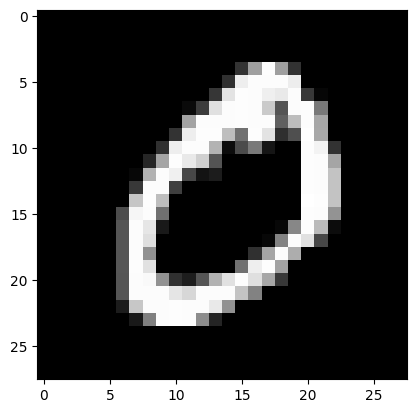

In [6]:
imgs = []
imgs_test = []
for digit_index in range(len(digits)):
    imgs.append(np.resize(X_train3[digit_index], (len(X_train3[digit_index]), 28, 28)) / 255)
    imgs_test.append(np.resize(X_test3[digit_index], (len(X_test3[digit_index]), 28, 28)) / 255)

plt.imshow(imgs[0][0])
plt.show()

Resizing, Normalizing and converting the images to binary

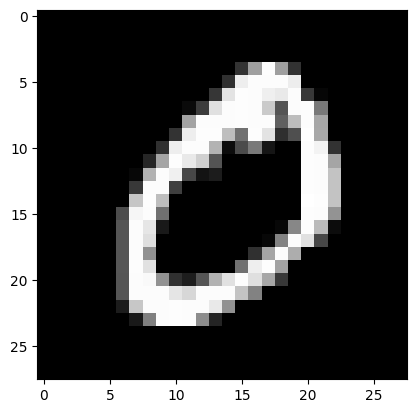

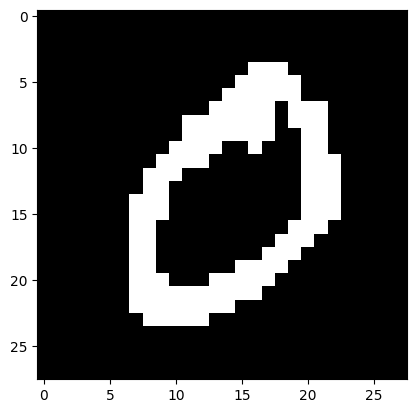

In [7]:
# Resizing images
images_resized = []
images_resized_test = []
for digit_index in range(len(digits)):
    images_resized.append([resize(img, (image_width, image_height), anti_aliasing=True) for img in imgs[digit_index]])
    images_resized_test.append([resize(img, (image_width, image_height), anti_aliasing=True) for img in imgs_test[digit_index]])

    # images_resized = [resize(img, (image_width, image_height), anti_aliasing=True) for img in imgs]

# Normalizing images

images_normalized = []
images_normalized_test = []

for digit_index in range(len(digits)):
    images_normalized.append([cv.normalize(image_resized, image_resized, 0, 255, cv.NORM_MINMAX) for image_resized in images_resized[digit_index]])
    images_normalized_test.append([cv.normalize(image_resized, image_resized, 0, 255, cv.NORM_MINMAX) for image_resized in images_resized_test[digit_index]])

    # images_normalized = [cv.normalize(image_resized, image_resized, 0, 255, cv.NORM_MINMAX) for image_resized in images_resized]

plt.imshow(images_normalized[0][0])
plt.show()

#Converting to binary

data = []
data_test = []
for digit_index in range(len(digits)):
    data.append([np.where(image_resized > THRESHOLD, 1, 0) for image_resized in images_resized[digit_index]])
    data_test.append([np.where(image_resized > THRESHOLD, 1, 0) for image_resized in images_resized_test[digit_index]])

# data = [np.where(image_resized > THRESHOLD, 1, 0) for image_resized in images_resized]

plt.imshow(data[0][0])
plt.show()

Flattening images

In [8]:
input_data = []
input_data_test = []
for digit_index in range(len(digits)):
    input_data.append([x.flatten().tolist() for x in data[digit_index]])
    input_data_test.append([x.flatten().tolist() for x in data_test[digit_index]])

print(input_data[0][0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 

In [9]:
result_picture_tab = []
for digit_index in range(len(digits)):
    result_picture_tab.append(np.mean(input_data_test[digit_index], axis = 0))

Shuffling training data

In [10]:
for digit in digits:
    flat_input_data = [item for sublist in input_data for item in sublist]
    flat_input_data_test = [item for sublist in input_data_test for item in sublist]

random.shuffle(flat_input_data)
random.shuffle(flat_input_data_test)

### Algorithm

Training

Learning params:


*  n_hidden: number of neurons in hidden layer.
*   qpu: whether to use real D-wave's qpu (requires setup) or a local simulator.
*  epochs: number of epochs.
*  lr: learning rate.



In [11]:
# BM Parameters
n_hidden = 30
qpu = False
epochs = 1000
lr = 0.1

In [12]:
bm = MSQRBM(n_visible=len_x, n_hidden=n_hidden, qpu=qpu)
bm.image_height = image_height
bm.tqdm = tqdm
bm.result_picture_tab = result_picture_tab

  0%|          | 0/1000 [00:00<?, ?it/s]

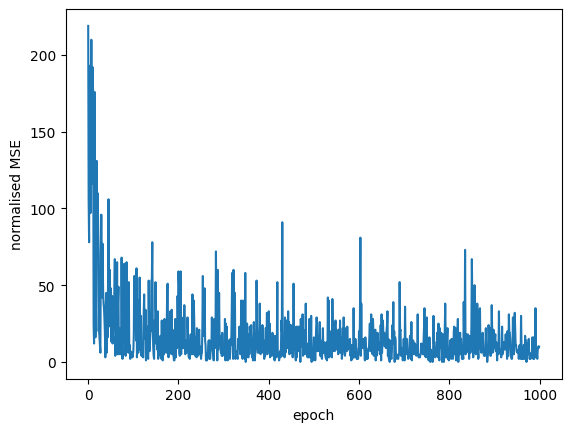

In [13]:
bm.train(flat_input_data, len_x, len_y, epochs = epochs, lr = lr, lr_decay = 0.1)

**Generation**

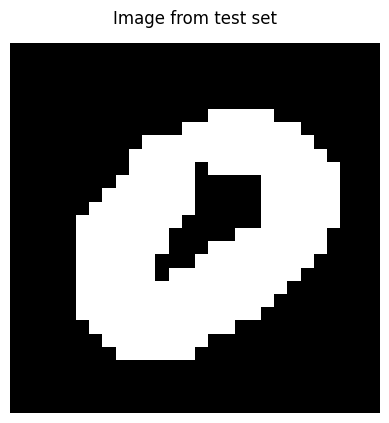

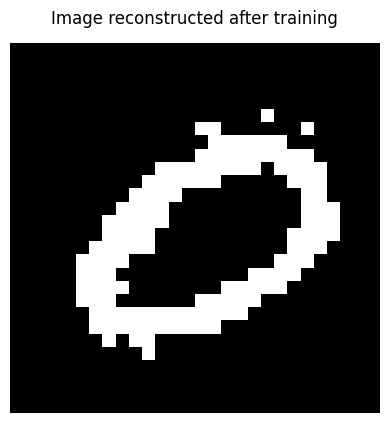

evaluation:  59.94387963348605
-------------------------------------


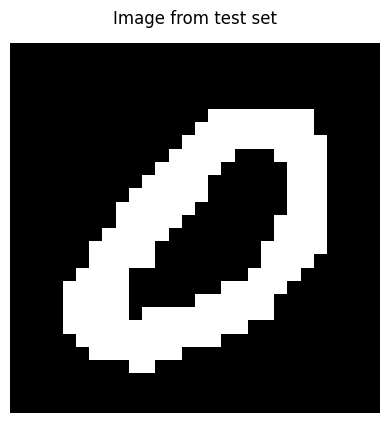

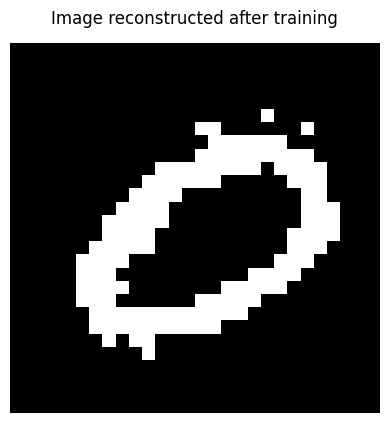

evaluation:  59.94387963348605
-------------------------------------


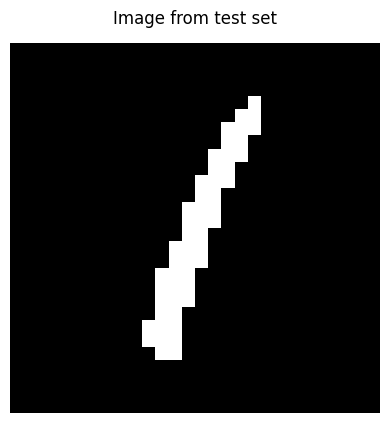

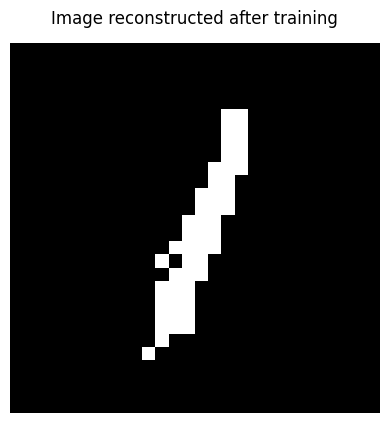

evaluation:  19.50281123250985
-------------------------------------


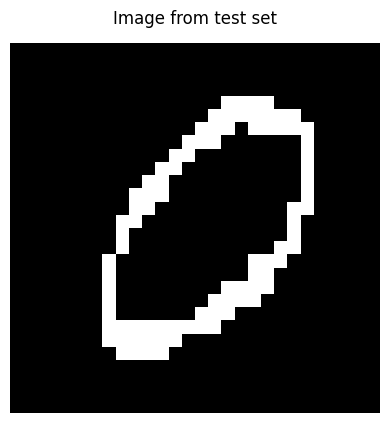

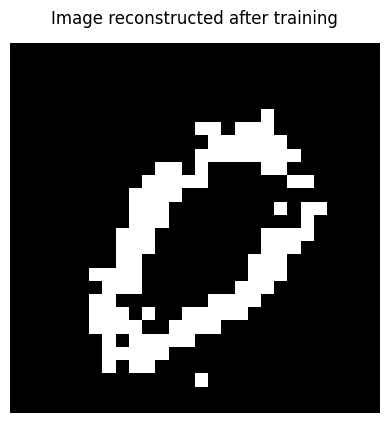

evaluation:  56.698981674302374
-------------------------------------


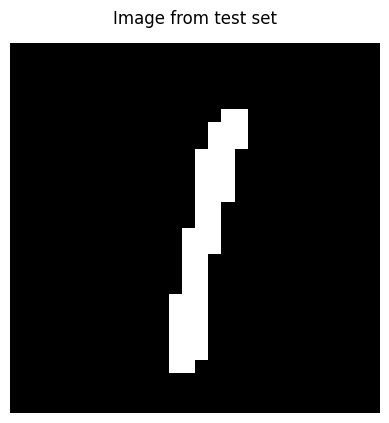

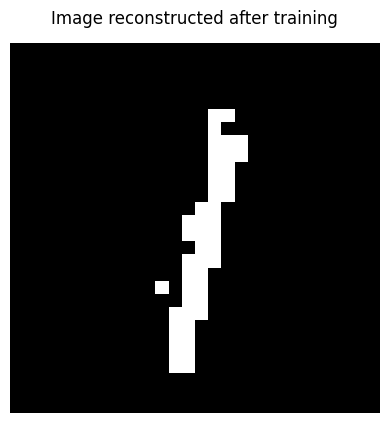

evaluation:  20.472855285373285
-------------------------------------


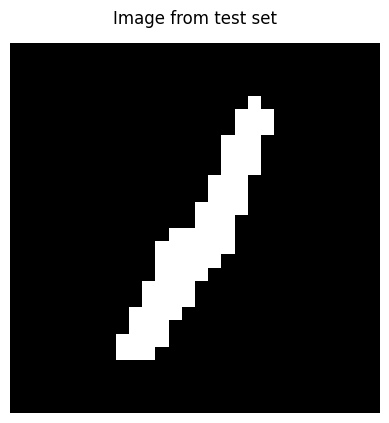

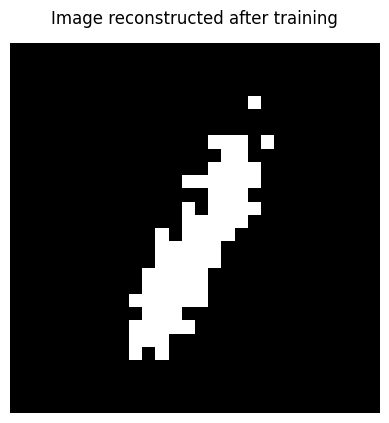

evaluation:  32.26844999902967
-------------------------------------


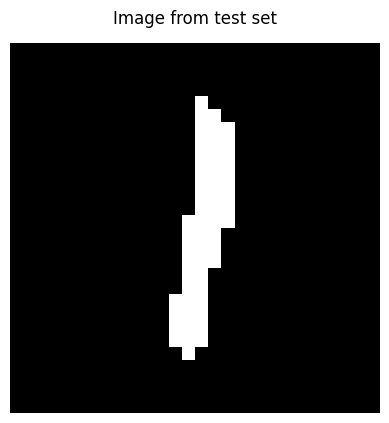

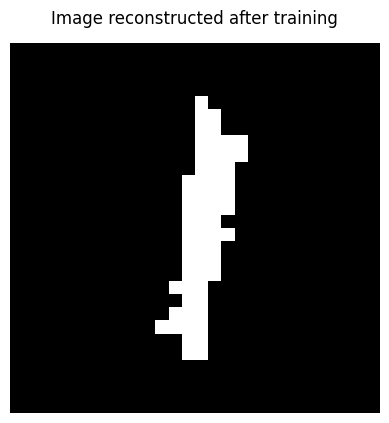

evaluation:  17.36800947039531
-------------------------------------


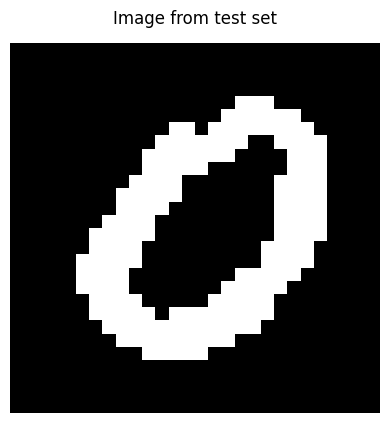

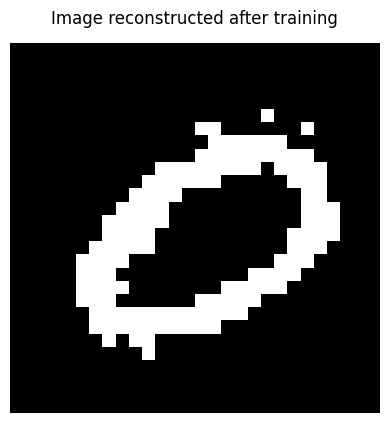

evaluation:  59.94387963348605
-------------------------------------


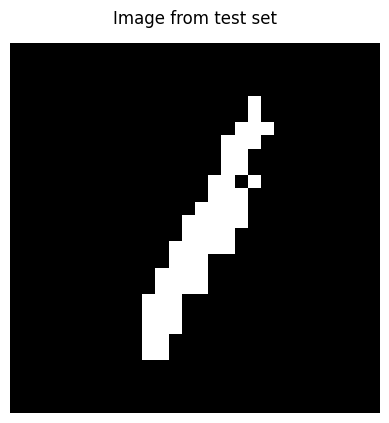

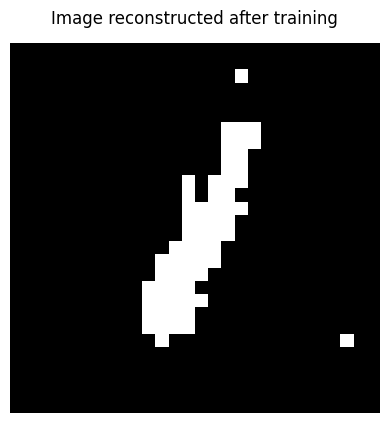

evaluation:  25.501049117972403
-------------------------------------


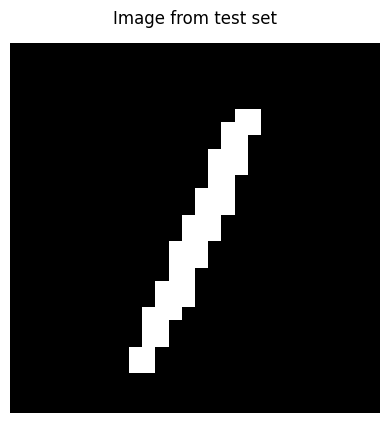

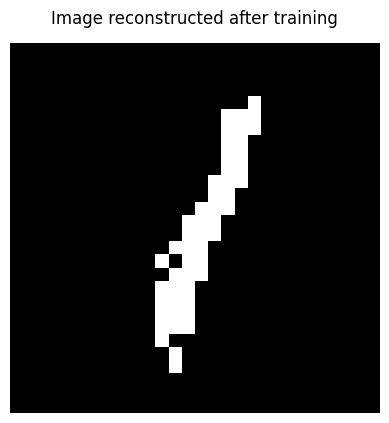

evaluation:  23.668449999029676
-------------------------------------


In [21]:
for test in range(10):
    flat_input_data_test_img = np.reshape(flat_input_data_test[test], (image_width, image_height))
    generated_pic = bm.generate(test_img = flat_input_data_test[test])
    evaluation = bm.evaluate(generated_pic, flat_input_data_test[test])

    plt.figure()
    plt.axis('off')
    plt.title("Image from test set", y=1.03)
    plt.imshow(flat_input_data_test_img)
    plt.show()

    plt.figure()
    plt.axis('off')
    plt.title("Image reconstructed after training", y=1.03)
    plt.imshow(np.array(generated_pic).reshape(image_height, -1))
    plt.show()


    print("evaluation: ", evaluation)
    print("-------------------------------------")

##Some Notes on the method:

###Gibbs Sampling

1. **Initialize** the visible units $$v$$ (either randomly, or to your “test” image if you’re doing a reconstruction).
2. **Sample** each hidden unit $$h_j$$ from  
   $$
   p(h_j = 1 \mid v) = \sigma\left(b_j + (W^\top v)_j\right).
   $$
3. **Sample** each visible unit $$v_i$$ from  
   $$
   p(v_i = 1 \mid h) = \sigma\left(a_i + (W h)_i\right).
   $$
4. **Repeat** steps 2–3 for a few (or many) iterations.  
   Eventually your $(v, h)$ chain wanders into one of the low-energy “valleys” the model learned.

> **Note:** There is no “test‐time gradient descent” on the energy surface; instead, the random updates of a Gibbs chain naturally drift toward low‐energy configurations.

---



### Putting it all together

**Train:** Adjust $(W, a, b)$ so that  $p(v) = \frac{1}{Z} \sum_h e^{-E(v, h)}$ puts most of its mass on your training images.

**Reconstruct / Generate:**
- *Reconstruction*  clamps the visible units initially to your test image, then does 1–2 steps of Gibbs sampling to “clean up” noise.
- *Free generation* starts $v$ at random and runs many Gibbs steps until you land in a learned mode.

**Evaluation:**  
Once you’ve sampled your reconstructed $v$, you compare it to the original test vector (e.g., via mean-squared error).

---
Overall method:
During training, you clamp the visible layer to each data vector and learn weights so that the hidden layer captures its correlations. During generation (or reconstruction), you sample back and forth between hidden and visible layers via Gibbs sampling—always producing your new image on the visible layer.


Interpretation: hidden units represent features (e.g.\ edges, strokes), not direct reconstructions. You must always sample back to the visible units to produce an actual image


Notes Generated with ChatGPT and improved for a fast explanation of gibbs sampling and the training procedure of Boltzmann machines.

### References



*  Applying a Quantum Annealing Based Restricted Boltzmann Machine for MNIST Handwritten Digit Classification [CMST paper](https://cmst.eu/articles/applying-a-quantum-annealing-based-restricted-boltzmann-machine-for-mnist-handwritten-digit-classification/)
*  Mareksubocz github implementation from the paper: https://github.com/mareksubocz/QRBM